# Prompt Chaining
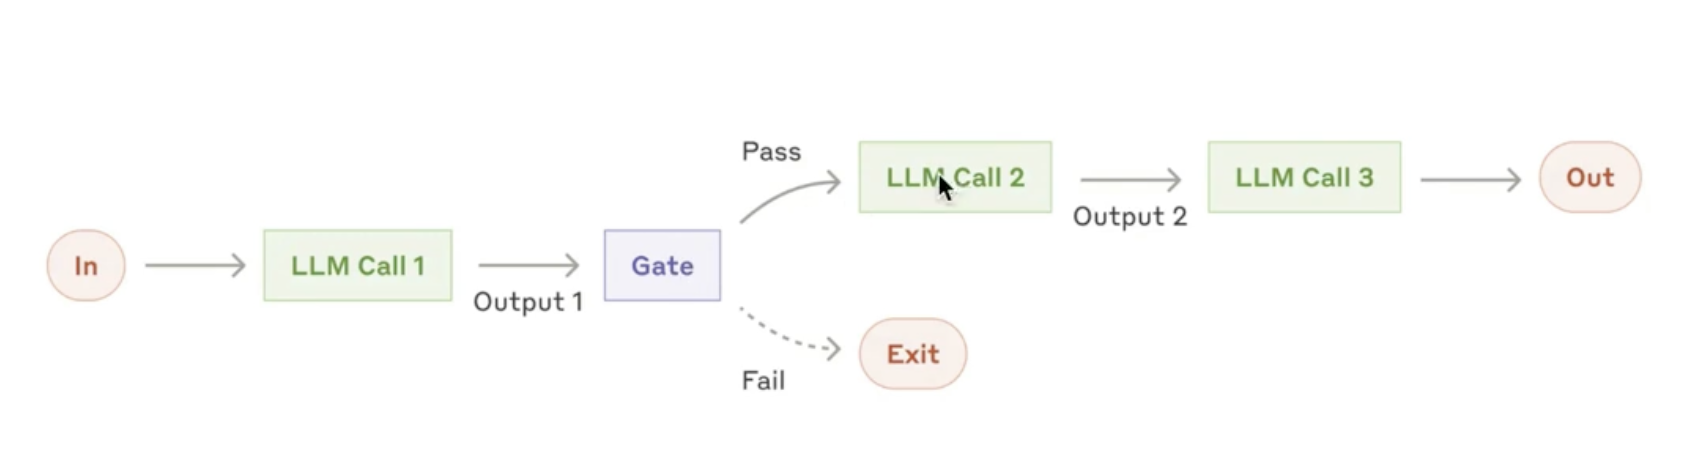

- 작업들을 단계들의 순서로 쪼개서 각 LLM 호출이 이전 단계의 호출을 받음.
- 고정된 하위 작업으로 깔끔하게 분해할 수 있을 때 사용
- 주요 목표는 더 높은 정확도를 얻는 것. -> 속도는 조금 더 느림
- example: 홍보 문안, 번역, 문서 개요
- Gate : 프로세스가 잘 진행되고 있는지 확인하는 검증 단계

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str

class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str

class IngredientsOutput(BaseModel):
    ingredients: list[Ingredient]

In [18]:
# nodes coming soon
def list_ingredients(state: State):
    structured_llm = llm.with_structured_output(IngredientsOutput)
    response = structured_llm.invoke(f"List 5-8 ingredients needed to make {state['dish']}")

    return {"ingredients": response.ingredients}

def create_recipe(state: State):
    response = llm.invoke(f"Write a step by step cooking instruction for {state['dish']} using these ingredients {state['ingredients']}")

    return {"recipe_steps": response.content}
    
def describe_plating(state: State):
    response = llm.invoke(f"Describe how to beautifully plate this dish {state['dish']} based on this recipe {state['recipe_steps']}")

    return {"plate_description": response.content}

def gate(state: State):
    ingredients = state["ingredients"]

    if len(ingredients) > 8 or len(ingredients) < 3:
        return False
    
    return True

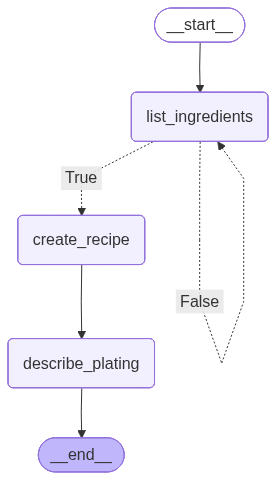

In [20]:
graph_builder = StateGraph(State)
graph_builder.add_node(list_ingredients.__name__, list_ingredients)
graph_builder.add_node(create_recipe.__name__, create_recipe)
graph_builder.add_node(describe_plating.__name__, describe_plating)

graph_builder.add_edge(START, list_ingredients.__name__)
graph_builder.add_conditional_edges(list_ingredients.__name__, gate, {True: create_recipe.__name__, False: list_ingredients.__name__})
graph_builder.add_edge(create_recipe.__name__, describe_plating.__name__)
graph_builder.add_edge(describe_plating.__name__, END)

graph = graph_builder.compile()
graph

In [17]:
graph.invoke({"dish": "hummus"})

{'dish': 'hummus',
 'ingredients': [Ingredient(name='Chickpeas', quantity='1', unit='can (15 oz)'),
  Ingredient(name='Tahini', quantity='1/4', unit='cup'),
  Ingredient(name='Olive oil', quantity='2', unit='tablespoons'),
  Ingredient(name='Garlic', quantity='2', unit='cloves'),
  Ingredient(name='Lemon juice', quantity='2', unit='tablespoons'),
  Ingredient(name='Ground cumin', quantity='1', unit='teaspoon'),
  Ingredient(name='Salt', quantity='1/2', unit='teaspoon'),
  Ingredient(name='Water', quantity='2-4', unit='tablespoons')],
 'recipe_steps': 'Here’s a step-by-step guide to making delicious hummus using your specified ingredients:\n\n### Ingredients:\n- 1 can (15 oz) Chickpeas\n- 1/4 cup Tahini\n- 2 tablespoons Olive oil\n- 2 cloves Garlic\n- 2 tablespoons Lemon juice\n- 1 teaspoon Ground cumin\n- 1/2 teaspoon Salt\n- 2-4 tablespoons Water\n\n### Instructions:\n\n1. **Prepare the Chickpeas**:\n   - Open the can of chickpeas and drain the liquid. Rinse the chickpeas under cold w

# Routing

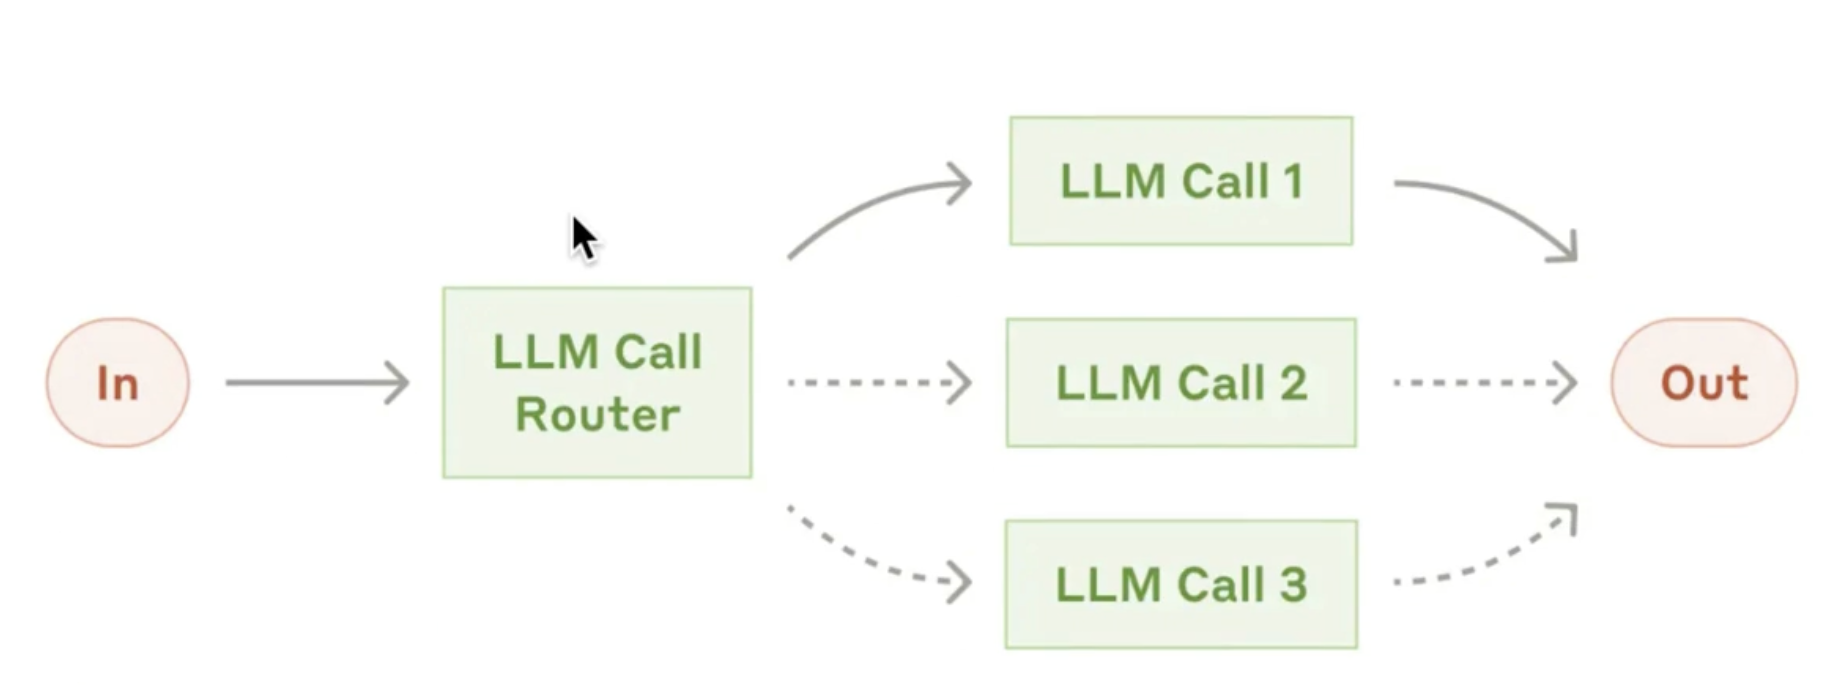

- 모든 상황을 하나의 큰 프롬프트를 만드는 것보다 각기 다른 입력에 특화된 노드를 만들고 입력을 전달한다.
  - 다양한 시나리오에 최적화할 수 있다.
- 복잡한 작업에 잘 작동한다.
- 요청을 정확하게 분류할 수 있는 경우에 사용.
- 다양한 유형의 고객 서비스 요청을 안내하는데 유용.
- 각 요청에 따라 다른 모델을 사용해서 비용과 속도를 최적화 할 수 있다.


In [38]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o-mini")

dumb_llm = init_chat_model("openai:gpt-3.5-turbo")
average_llm = init_chat_model("openai:gpt-4o")
smart_llm = init_chat_model("openai:gpt-5-2025-06-10")

class State(TypedDict):
    question: str
    difficulty: str
    answer: str
    model_used: str

class DifficultyResponse(BaseModel):
    difficulty: Literal["easy", "medium", "hard"]

In [42]:
from langgraph.types import Command


def dumb_node(state: State):
    response = dumb_llm.invoke(state["question"])

    return { "answer": response.content, "model_used": "gpt-3.5" }

def average_node(state: State):
    response = average_llm.invoke(state["question"])
    
    return { "answer": response.content, "model_used": "gpt-4o" }

def smart_node(state: State):
    response = smart_llm.invoke(state["question"])
    
    return { "answer": response.content, "model_used": "gpt-5" }

def assess_difficulty(state: State):
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(f"""
    Assess the difficulty of this question
    Question: {state['question']}
    
    - Easy : Simple facts, basic definitions, yes/no answers
    - MEDIUM: Requires explanation, comparsion, analysis
    - HARD : Complex reasining, multiple steps, deep expertise.
    """)

    difficulty_level = response.difficulty

    if difficulty_level == "easy":
        goto = dumb_node.__name__
    elif difficulty_level == "medium":
        goto = average_node.__name__
    elif difficulty_level == "hard":
        goto = smart_node.__name__
    
    return Command(goto=goto, update={"difficulty": difficulty_level})
    

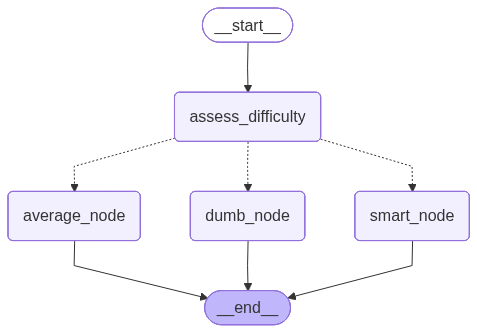

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node(dumb_node.__name__, dumb_node)
graph_builder.add_node(average_node.__name__, average_node)
graph_builder.add_node(smart_node.__name__, smart_node)
# destinations로 노드들이 실제 연결되어있지 않아도 가시성을 위해 사용할 수 있다.
graph_builder.add_node(assess_difficulty.__name__, assess_difficulty, destinations=(dumb_node.__name__, average_node.__name__, smart_node.__name__))


graph_builder.add_edge(START, assess_difficulty.__name__)
graph_builder.add_edge(dumb_node.__name__, END)
graph_builder.add_edge(average_node.__name__, END)
graph_builder.add_edge(smart_node.__name__, END)

graph = graph_builder.compile()
graph

In [37]:
graph.invoke({"question": "Capital of Poland"})

{'question': 'Capital of Poland',
 'difficulty': 'easy',
 'answer': 'The capital of Poland is Warsaw.',
 'model_used': 'gpt-3.5'}

In [ ]:
graph.invoke({"question": "Investment potential of Uranium of 2026"})

# Parallelization
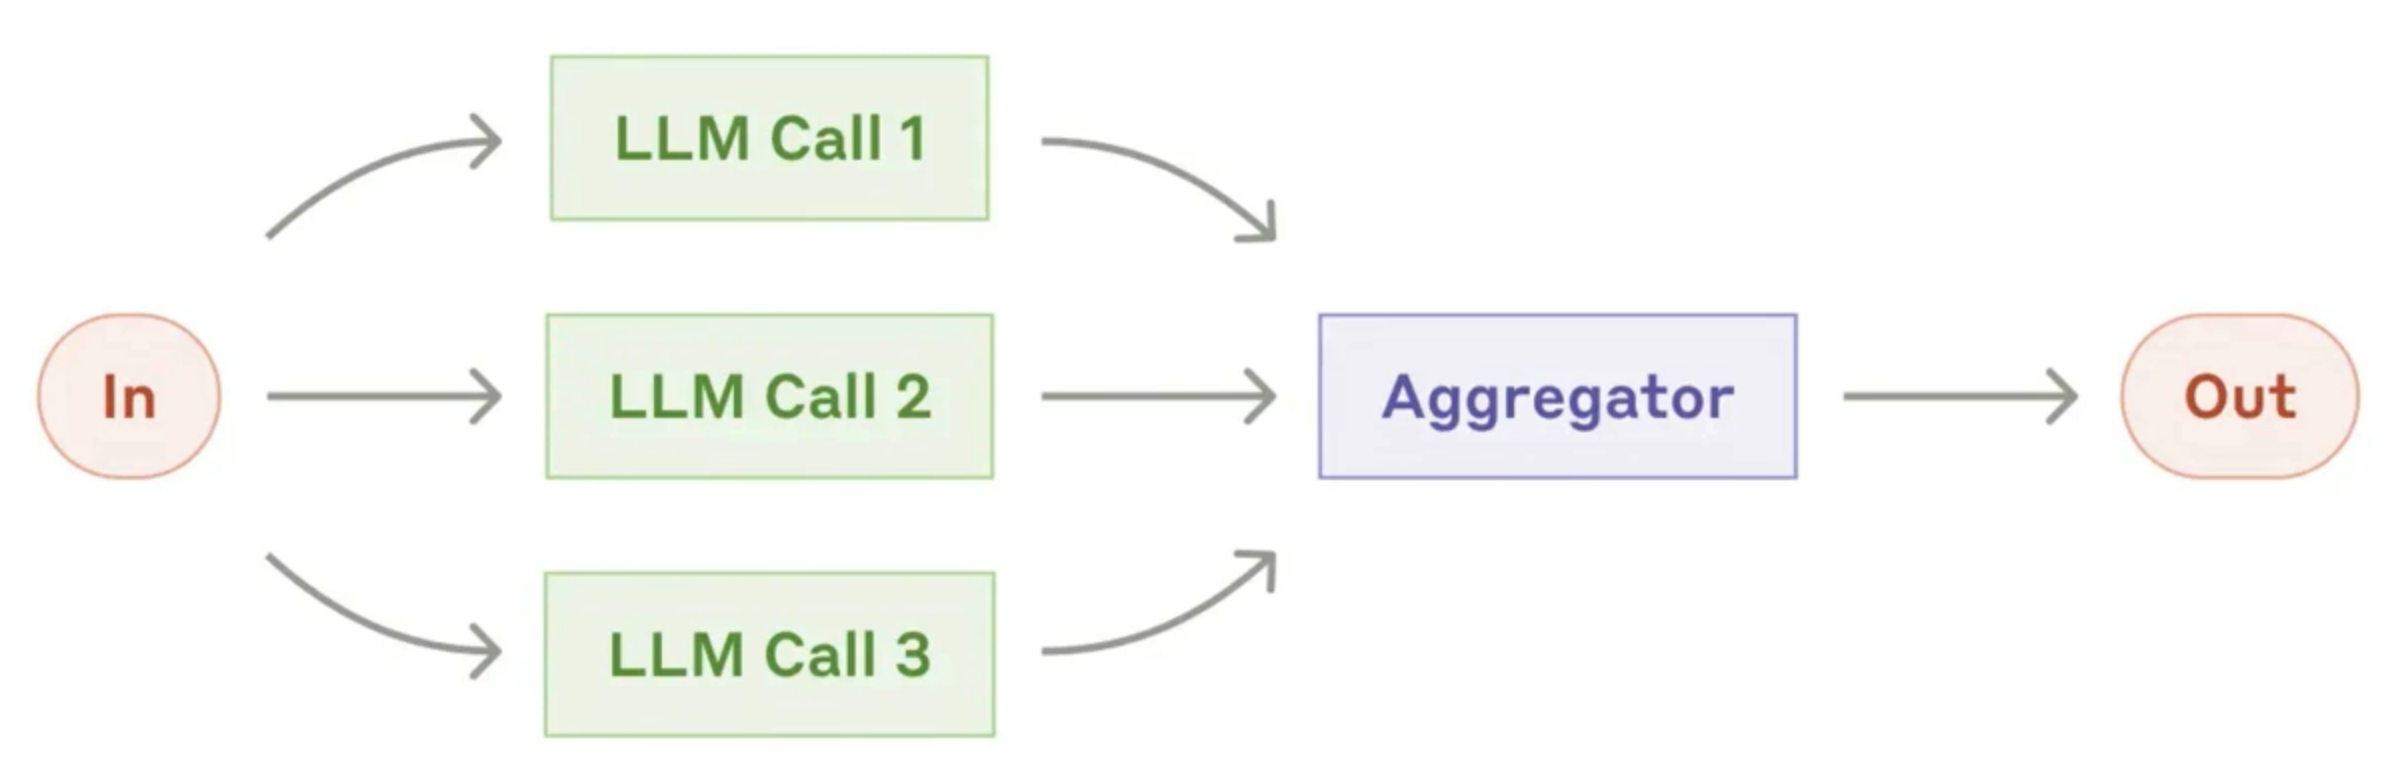

- Sectioning : 독립서브태스크로 나눠서 병렬 수행
- Voting : 같은 작업을 여러번 수행하면서 다른 출력을 얻어낼 수 있다.
  - Aggregate : 같은 input의 다른 output들을 집계 (어떤 응답이 좋은가 ?)

In [1]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o-mini")

dumb_llm = init_chat_model("openai:gpt-3.5-turbo")
average_llm = init_chat_model("openai:gpt-4o")
smart_llm = init_chat_model("openai:gpt-5-2025-06-10")

class State(TypedDict):
    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str


In [5]:
def get_summary(state: State):
    response = llm.invoke(f"Write a 3-sentence summary of this document {state['document']}")
    return {
        "summary": response.content
    }
    
def get_sentiment(state: State):
    response = llm.invoke(f"Analyze the sentiment and tone of this document {state['document']}")
    return {
        "sentiment": response.content
    }
    
def get_keypoints(state: State):
    response = llm.invoke(f"List the 5 most important points of this document {state['document']}")
    return {
        "keypoints": response.content
    }
    
def get_recommendation(state: State):
    response = llm.invoke(f"Based on this document, list 3 recommended next steps {state['document']}")
    return {
        "recommendation": response.content
    }
    
def get_final_analysis(state: State):
    response = llm.invoke(f"""
Give me an analysis of the following report

DOCUMENT ANALYSIS REPORT
========================

EXECUTIVE SUMMARY:
{state['summary']}

SENTIMENT ANALYSIS:
{state['sentiment']}

KEY POINTS:
{state.get("key_points", "")}

RECOMMENDATIONS:
{state.get('recommendation', "N/A")}""")
    return {
        "final_analysis": response.content
    }

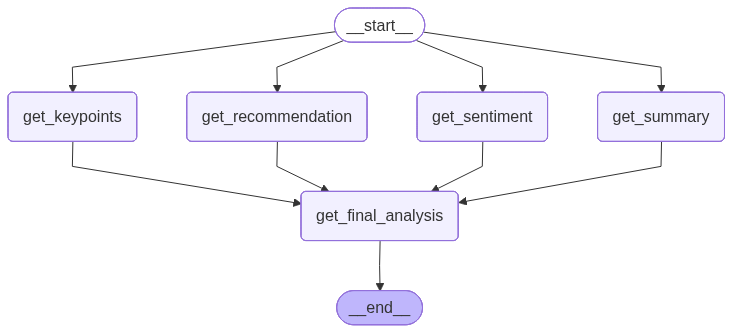

In [6]:
graph_builder = StateGraph(State)

graph_builder.add_node(get_summary.__name__, get_summary)
graph_builder.add_node(get_sentiment.__name__, get_sentiment)
graph_builder.add_node(get_keypoints.__name__, get_keypoints)
graph_builder.add_node(get_recommendation.__name__, get_recommendation)
graph_builder.add_node(get_final_analysis.__name__, get_final_analysis)

graph_builder.add_edge(START, get_summary.__name__)
graph_builder.add_edge(START, get_sentiment.__name__)
graph_builder.add_edge(START, get_keypoints.__name__)
graph_builder.add_edge(START, get_recommendation.__name__)
graph_builder.add_edge(get_summary.__name__, get_final_analysis.__name__)
graph_builder.add_edge(get_sentiment.__name__, get_final_analysis.__name__)
graph_builder.add_edge(get_keypoints.__name__, get_final_analysis.__name__)
graph_builder.add_edge(get_recommendation.__name__, get_final_analysis.__name__)

graph = graph_builder.compile()

graph

In [7]:
with open("fed_transcript.md", "r", encoding="utf-8") as f:
    document = f.read()
    
for chunk in graph.stream({"document": document}, stream_mode="updates"):
    print(chunk, "\n")
    

{'get_summary': {'summary': 'In a recent statement, the Federal Open Market Committee (FOMC) announced a quarter percentage point reduction in interest rates to support maximum employment and stable prices amid slowing job growth and elevated inflation. Economic activity has moderated, with GDP growth projected at 1.6% for the year, and concerns about the labor market have grown as the unemployment rate edged up to 4.3%, with job creation falling behind break-even levels. The committee continues to assess the balance of risks in monetary policy while emphasizing its commitment to achieving its dual mandate goals for the American people.'}} 

{'get_recommendation': {'recommendation': "Based on the document, here are three recommended next steps:\n\n1. **Monitor Economic Indicators Closely**: Continue to assess incoming data related to inflation, employment, and economic growth closely. This will help the Federal Open Market Committee (FOMC) make informed decisions about future monetary 